In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
from numpy import copy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
model = keras.models.load_model("FaceMask_model")
#model.summary()

In [3]:
df_train_all = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')
#y=df_train['label']
#X = df_train.drop(['label'], axis=1)
df_train, df_valid = train_test_split(df_train_all, test_size=0.15, stratify=df_train_all['label'], random_state=1)

In [4]:
#Number of images used in the traininng after Augmentation 
df_train_all['label'].value_counts()

without_mask             2280
with_mask                2158
mask_incorrectly_worn    2111
Name: label, dtype: int64

In [5]:
#Number of images used in the traininng after validation split 
df_train['label'].value_counts()

without_mask             1938
with_mask                1834
mask_incorrectly_worn    1794
Name: label, dtype: int64

In [6]:
#Number of images used in validation 
df_valid['label'].value_counts()

without_mask             342
with_mask                324
mask_incorrectly_worn    317
Name: label, dtype: int64

In [7]:
#Test data counts
df_test['label'].value_counts()

with_mask                719
without_mask             152
mask_incorrectly_worn     30
Name: label, dtype: int64

In [8]:
#datagenTrain = ImageDataGenerator(rescale=1./255, validation_split=0.25 )
datagen = ImageDataGenerator(rescale=1./255)


trainData=datagen.flow_from_dataframe(
dataframe=df_train,
directory="./TrainTestData/",
x_col="cropped_image_file",
y_col="label",
batch_size=50,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32),
interpolation='nearest',
subset='training'
)

validData=datagen.flow_from_dataframe(
dataframe=df_valid,
directory="./TrainTestData/",
x_col="cropped_image_file",
y_col="label",
batch_size=50,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32),
interpolation='nearest',
#subset='validation'
)

testData=datagen.flow_from_dataframe(
dataframe=df_test,
directory="./TrainTestData/",
x_col="cropped_image_file",
y_col="label",
batch_size=50,
seed=42,
shuffle=False,
#class_mode="categorical",
target_size=(32,32),
interpolation='nearest')

Found 5566 validated image filenames belonging to 3 classes.
Found 983 validated image filenames belonging to 3 classes.
Found 901 validated image filenames belonging to 3 classes.


In [9]:
history = model.fit(
        trainData,
        steps_per_epoch=trainData.n//trainData.batch_size,
        validation_data = validData,
        validation_steps =validData.n//validData.batch_size,
        epochs=50 
    
        )
model.save_weights('try1.h5')  # 

Epoch 1/50
111/111 [==============================] - 13s 98ms/step - loss: 0.8823 - accuracy: 0.5419 - val_loss: 0.6452 - val_accuracy: 0.7158
Epoch 2/50
111/111 [==============================] - 7s 60ms/step - loss: 0.5588 - accuracy: 0.7690 - val_loss: 0.5473 - val_accuracy: 0.7874
Epoch 3/50
111/111 [==============================] - 7s 59ms/step - loss: 0.5045 - accuracy: 0.7971 - val_loss: 0.5547 - val_accuracy: 0.7737
Epoch 4/50
111/111 [==============================] - 7s 62ms/step - loss: 0.4752 - accuracy: 0.8113 - val_loss: 0.4376 - val_accuracy: 0.8295
Epoch 5/50
111/111 [==============================] - 7s 65ms/step - loss: 0.4278 - accuracy: 0.8372 - val_loss: 0.4167 - val_accuracy: 0.8368
Epoch 6/50
111/111 [==============================] - 7s 66ms/step - loss: 0.4054 - accuracy: 0.8464 - val_loss: 0.4327 - val_accuracy: 0.8242
Epoch 7/50
111/111 [==============================] - 7s 65ms/step - loss: 0.3851 - accuracy: 0.8577 - val_loss: 0.3798 - val_accuracy: 0.855

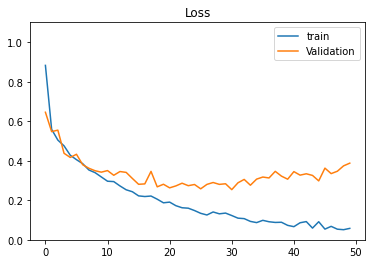

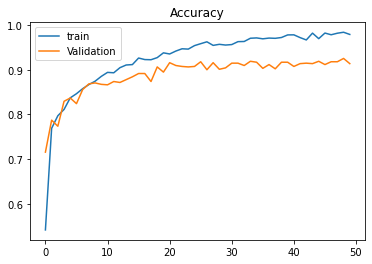

In [10]:
# evaluate the model
#_, train_acc = model.evaluate(Xtrain, ytrain, verbose=0)
#_, test_acc = model.evaluate(Xtest, ytest, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
#plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylim(0.0, 1.1)
plt.legend()
plt.show()
# plot accuracy during training
#plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='Validation')
#plt.ylim(0.0, 1.1)
plt.legend()
plt.show()

In [11]:
#Get labels map
label_map = (trainData.class_indices)
label_map

{'mask_incorrectly_worn': 0, 'with_mask': 1, 'without_mask': 2}

In [12]:
yhat_classes = model.predict(testData, verbose=0) #Gives prediction as propability
ypred = np.argmax(yhat_classes,axis=1) #Get labels from brobability
y_test_label = df_test['label'] #Read y_test
#Replace label names in y_test with the same labeling used by the model 
y_test = np.empty(len(y_test_label))
for k, v in label_map.items(): y_test[y_test_label==k] = v

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, ypred)

0.904550499445061

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred,target_names = label_map.keys() ))

                       precision    recall  f1-score   support

mask_incorrectly_worn       0.25      0.50      0.34        30
            with_mask       0.98      0.91      0.95       719
         without_mask       0.82      0.94      0.88       152

             accuracy                           0.90       901
            macro avg       0.69      0.78      0.72       901
         weighted avg       0.93      0.90      0.92       901



In [15]:
score = model.evaluate(testData, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

19/19 [==============================] - 1s 32ms/step - loss: 0.4369 - accuracy: 0.9046
Test loss: 0.43688708543777466
Test accuracy: 0.9045504927635193
